<a href="https://colab.research.google.com/github/HowardHNguyen/Python/blob/main/CIFAR10_ResNet_PyTorch_ADAM_Optimizer_MIN_of_GB_MIN_Weight_30epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classifications by ResNet Model Using PyTorch**

By Howard Nguyen

for ANLY 763, 11/20/2023

Recommend to run on GPU - V100

In [ ]:
# Load libraries
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
# Device configuration
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Preparing the CIFAR10 Dataset

Here are some images from the dataset:

![cifar10](https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png)


Let's begin by downloading the dataset and creating PyTorch datasets.

In [ ]:
from torchvision.datasets.utils import download_url

# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

100%|██████████| 135107811/135107811 [00:07<00:00, 17175408.06it/s]


['train', 'test']
['bird', 'frog', 'automobile', 'deer', 'cat', 'airplane', 'ship', 'horse', 'truck', 'dog']


In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # (RGB, SD)
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)),
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 500 to utlize a larger portion of the GPU RAM. We can try reducing the batch size & restarting the kernel if we face an "out of memory" error.

In [ ]:
batch_size = 400

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to denormalize the pixels values to bring them back into the range (0,1).

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

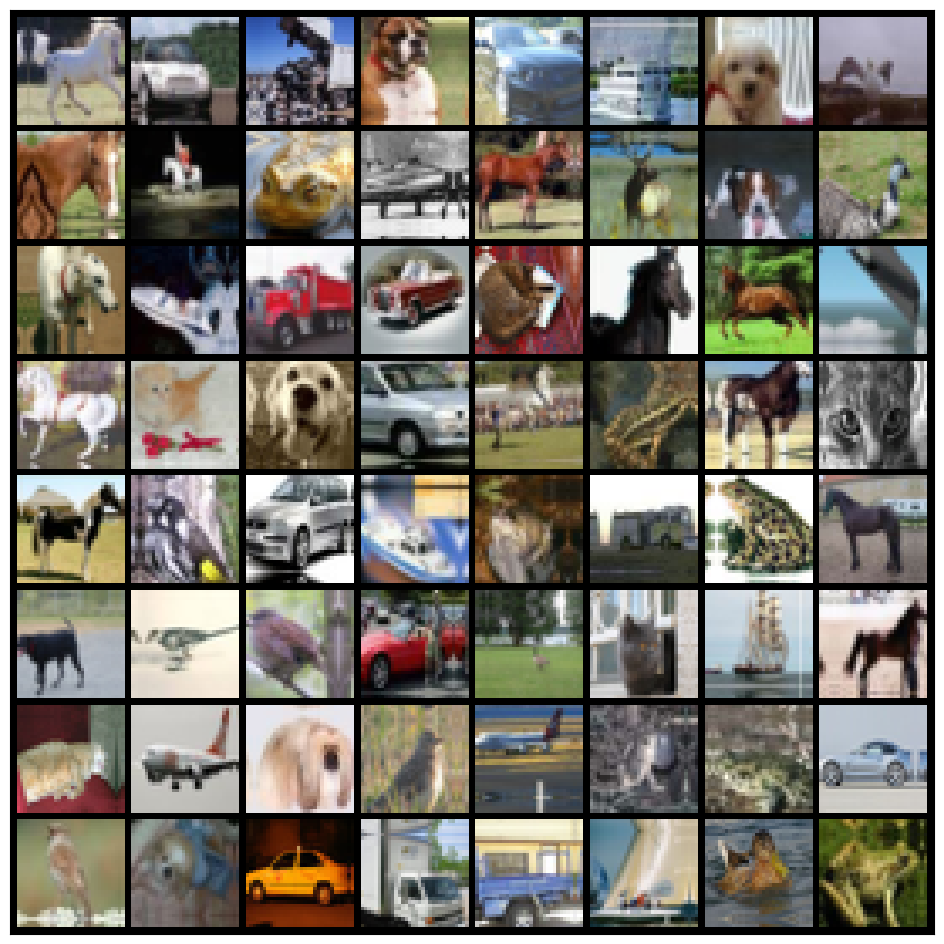

In [ ]:
show_batch(train_dl)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If we look closely, we can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Using a GPU

To seamlessly use a GPU, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where we're running this notebook, our default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the residual block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Here is a very simple Residual block:

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer.

In our case, we will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
                                                      # 3 x 32 x 32
        self.conv1 = conv_block(in_channels, 64)      # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True)   # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))  # 128 x 16 x 16

        self.conv3 = conv_block(128, 256, pool=True)  # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)  # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))  # 512 x 4 x 4

        self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512 x 1 x 1
                                        nn.Flatten(),    # 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes)) # 10

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Review the model

In [ ]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.301302194595337, 'val_acc': 0.09615384787321091}]

We're now ready to train our model. We'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. We can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html Then, later to compare with SGD and its configuration adjustment as well, to find the best performance results.

# **Performance Test on Adam optimizer**

In [ ]:
# Using Adam optimizer
epochs = 30
max_lr = 0.01        # Adjust based on learning rate range test
grad_clip = 0.1      # Adjusted to MIN of gradient behavior
weight_decay = 1e-4  # Adjust based on regularization needs
opt_func = torch.optim.Adam

In [ ]:
# Using Adam optimizer
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00069, train_loss: 1.5154, val_loss: 1.1181, val_acc: 0.5971
Epoch [1], last_lr: 0.00152, train_loss: 1.0113, val_loss: 0.9389, val_acc: 0.6777
Epoch [2], last_lr: 0.00279, train_loss: 0.8188, val_loss: 0.6724, val_acc: 0.7691
Epoch [3], last_lr: 0.00436, train_loss: 0.7126, val_loss: 0.9181, val_acc: 0.7096
Epoch [4], last_lr: 0.00603, train_loss: 0.6943, val_loss: 1.0034, val_acc: 0.6635
Epoch [5], last_lr: 0.00760, train_loss: 0.6193, val_loss: 0.9033, val_acc: 0.7038
Epoch [6], last_lr: 0.00888, train_loss: 0.5611, val_loss: 0.9022, val_acc: 0.7262
Epoch [7], last_lr: 0.00971, train_loss: 0.5165, val_loss: 1.2031, val_acc: 0.6529
Epoch [8], last_lr: 0.01000, train_loss: 0.4611, val_loss: 0.6479, val_acc: 0.7954
Epoch [9], last_lr: 0.00994, train_loss: 0.4309, val_loss: 0.5466, val_acc: 0.8246
Epoch [10], last_lr: 0.00978, train_loss: 0.4192, val_loss: 0.6706, val_acc: 0.7821
Epoch [11], last_lr: 0.00950, train_loss: 0.3964, val_loss: 0.6340, val_acc: 0.7881
Ep

In [ ]:
#train_time='8:00'

Our model trained to over **93.41% accuracy in 8.28 minutes**! Try playing around with the data augmentations, network architecture & hyperparameters to achive the following results:

1. 95% accuracy in under 10 minutes (easy)
2. 92% accuracy in under 2.5 minutes (intermediate)
3. 95% accuracy in under 5 minutes (hard)


Let's plot the valdation set accuracies to study how the model improves over time.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
# plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
# plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
# plot_lrs(history)

# Review all three charts on the same page
1 - Accuracy change over time

2 - Training vs Validation Loss rate over time

3 - Learning rate change over time

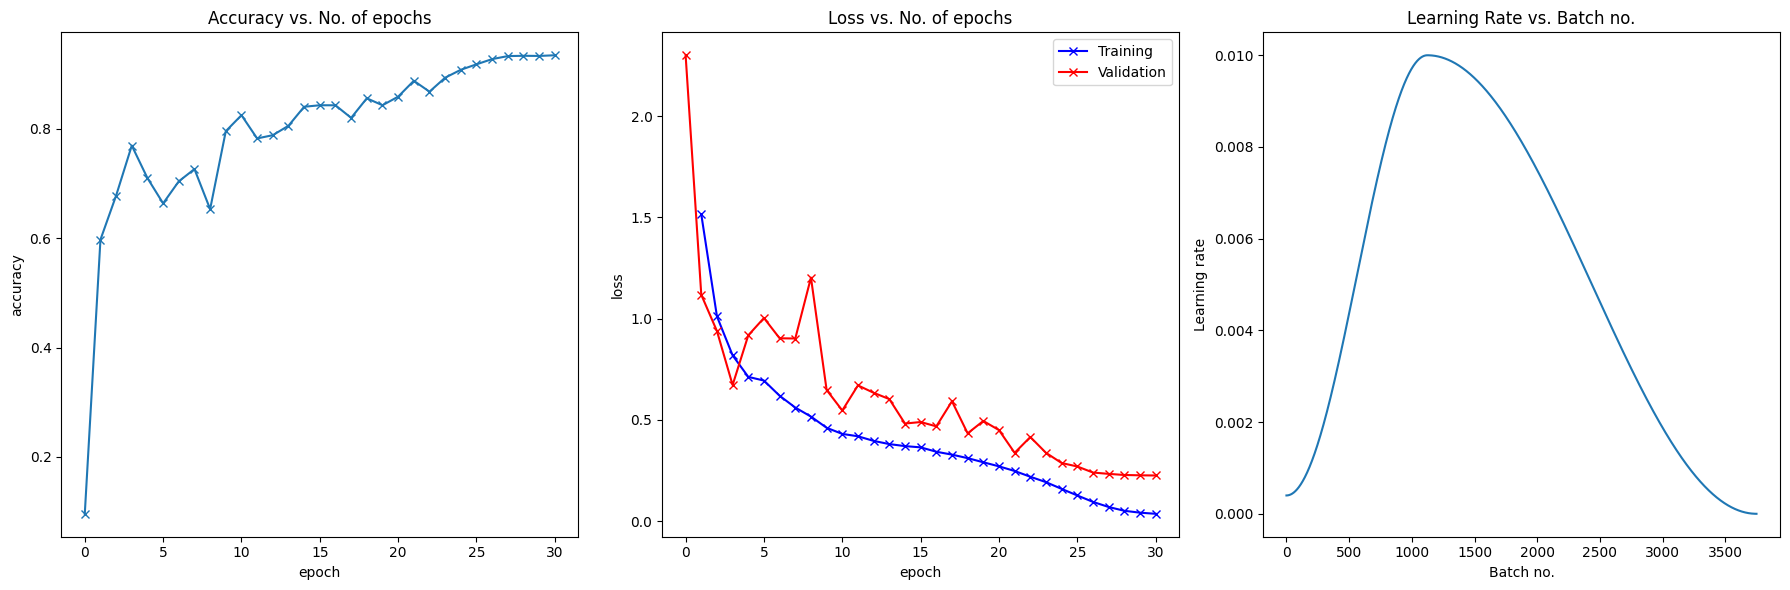

In [ ]:
# Create a single figure with three subplots (1 row, 3 columns)
plt.figure(figsize=(18, 6))

# Plot accuracies in the first subplot
plt.subplot(1, 3, 1)
plot_accuracies(history)

# Plot losses in the second subplot
plt.subplot(1, 3, 2)
plot_losses(history)

# Plot learning rates in the third subplot
plt.subplot(1, 3, 3)
plot_lrs(history)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

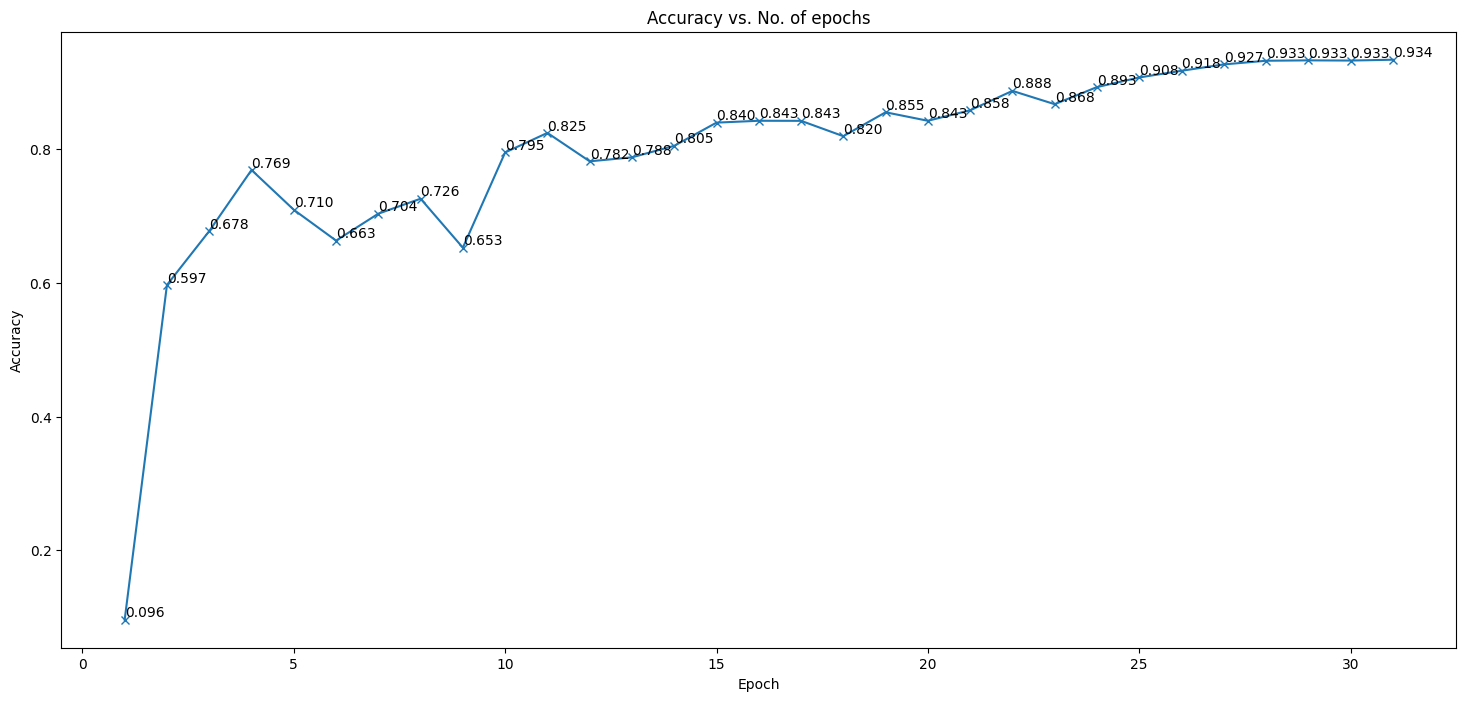

In [ ]:
# plot with showing values on the line chart
plt.figure(figsize=(18, 8))
def plot_accuracies(epochs, accuracies):
    plt.plot(epochs, accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of epochs')

    # Add numeric values to the plot
    for epoch, acc in zip(epochs, accuracies):
        plt.text(epoch, acc, f'{acc:.3f}', ha='left', va='bottom')

    plt.show()

# history = ...  # Define your history variable here
epochs = range(1, len(history) + 1)
accuracies = [x['val_acc'] for x in history]
plot_accuracies(epochs, accuracies)

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.


In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


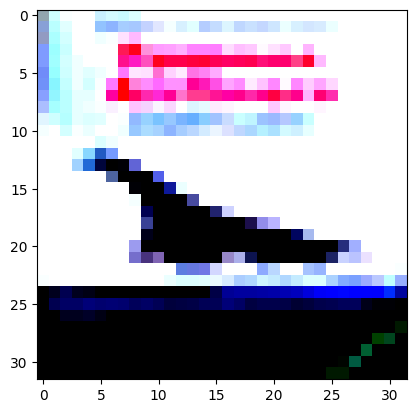

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


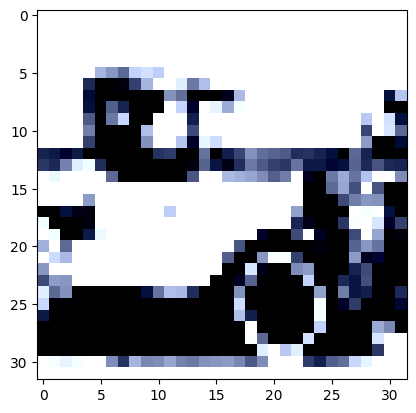

In [ ]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


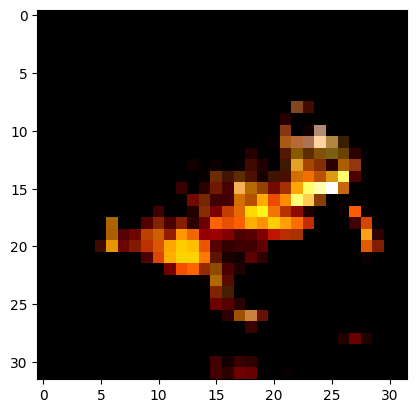

In [ ]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')

# **RESULTS:**

Below are the list of ten tests and its results:

**1 - Using Adam optimizer: tested on 30 epochs**

    + epochs = 30
    + max_lr = 0.01
    + grad_clip = 0.1      
    + weight_decay = 1e-4  

Result: the accuracy of the model on the training images: **93.41%** in 8.28 minutes.

**2 - Using Adam optimizer: tested on 20 epochs**

    + epochs = 20
    + max_lr = 0.01
    + grad_clip = 0.1      
    + weight_decay = 1e-4  

Result: the accuracy of the model on the training images: **93.12%** in 5.22 minutes.

**3 - Using Adam optimizer: tested on 10 epochs**

    + epochs = 10
    + max_lr = 0.01
    + grad_clip = 0.1      
    + weight_decay = 1e-4  

Result: the accuracy of the model on the training images: **91.66%** in 2.35 minutes.

**4 - Using Adam optimizer: tested on 10 epochs**

    + epochs = 10
    + max_lr = 0.01
    + grad_clip = 1.0     # Adjusted to MAX value of Gradient Behavior
    + weight_decay = 1e-4  

Result: the accuracy of the model on the training images: **91.45%** in 2.30 minutes.

**5 - Using Adam optimizer: tested on 10 epochs**

    + epochs = 10
    + max_lr = 0.01
    + grad_clip = 0.1     # Adjusted to MIN value of Gradient Behavior
    + weight_decay = 1e-2 # Adjusted to MAX value of Weight, it's based on regularization needs.

Result: the accuracy of the model on the training images: **79.80%** in 2.44 minutes.

**6 - Using Adam optimizer: tested on 10 epochs**

    + epochs = 10
    + max_lr = 0.01
    + grad_clip = 1.0     # Adjusted to MAX value of Gradient Behavior
    + weight_decay = 1e-2 # Adjusted to Higher value of Weight, it's based on regularization needs.

Result: the accuracy of the model on the training images: **79.94%** in 2.38 minutes.

===========================================================================

**7 - Using SGD optimizer: tested on 10 epochs**

    + epochs = 10
    + max_lr = 0.01
    + grad_clip = 0.1     # Adjusted to MIN value of Gradient Behavior
    + weight_decay = 1e-2 # Adjusted to Higher value of Weight, it's based on regularization needs.

Result: the accuracy of the model on the training images: **87.61%** in 2.33 minutes.

**8 - Using SGD optimizer: tested on 10 epochs**

    + epochs = 10
    + max_lr = 0.01
    + grad_clip = 1.0     # Adjusted to MAX value of Gradient Behavior
    + weight_decay = 1e-2 # Adjusted to Higher value of Weight, it's based on regularization needs.

Result: the accuracy of the model on the training images: **87.64%** in 2.44 minutes.

**9 - Using SGD optimizer: tested on 10 epochs**

    + epochs = 10
    + max_lr = 0.01
    + grad_clip = 1.0     # Adjusted to MAX value of Gradient Behavior
    + weight_decay = 1e-4 # Adjusted to Lower value of Weight, it's based on regularization needs.

Result: the accuracy of the model on the training images: **85.67%** in 2.41 minutes.

**10 - Using SGD optimizer: tested on 10 epochs**

    + epochs = 10
    + max_lr = 0.01
    + grad_clip = 0.1     # Adjusted to MIN value of Gradient Behavior
    + weight_decay = 1e-4 # Adjusted to Lower value of Weight, it's based on regularization needs.

Result: the accuracy of the model on the training images: **86.24%** in 2.42 minutes.

# **CONCLUSION**

The best model is the one we use with Adam optimizer with training on 30 epochs with learning rate of 0.01, gradient behavior of 0.1, and weight decay of 10e-4 (0.00001). However, it took 8.28 minutes to get the result of 93.41% of accuracy.